# Unit Commitment

_**[Power Systems Optimization](https://github.com/east-winds/power-systems-optimization)**_

_by Michael R. Davidson and Jesse D. Jenkins (last updated: October 11, 2022)_

This notebook will build on the economic dispatch (ED) model by introducing binary startup (called "commitment") decisions, constraints, and costs of thermal generators. Similar to ED, it minimizes the short-run production costs of meeting electricity demand, but these additions are necessary for operating systems with large amounts of (inflexible) thermal generation. They also entail significant computational trade-offs.

****

We build up the model in several stages. We first start with the simplest model that incorporates unit commitment decisions in order to understand the logic of three-variable commitment formulations.

Next, we introduce moderate complexity through the addition of ramp constraints&mdash;which we need to be modified from the ED to account for startups and shutdowns.

Finally, we model a more realistic unit commitment that includes reserves&mdash;an important feature of day-ahead scheduling in power systems.

## Introduction to unit commitment

Engineering considerations severely limit the possible output ranges of power plants. System operators need to be aware of these limitations when scheduling generation to meet demand. Thermal power plants, in particular, due to their complex designs, thermodynamic cycles, and material properties, can be particularly challenging. In practice, due to the times involved in bringing these power plants online, much of this scheduling is done day-ahead, which gives rise to the need for a day-ahead market.

**Unit commitment** (UC) is the problem of minimizing short-run costs of production inclusive of production and startup costs, in order to meet a given demand and considering relevant engineering constraints of the generators. It is built on the ED model in that it typically considers all of the same variables in addition to the new startup-related variables and constraints&mdash;hence, it is also sometimes called unit commitment and economic dispatch (UCED). This notebook, for simplicity, only considers a single-bus case, while typical formulations usually include a simplified network representation.

## Simple unit commitment

We start with the simplest case that incorporates unit commitment, building on the `economic_dispatch_multi` problem of the [Economic Dispatch notebook](04-Economic-Dispatch.ipynb).


$$
\begin{align}
\min \ & \sum_{g \in G, t \in T} VarCost_g \times GEN_{g,t} + \sum_{g \in G_{thermal}, t \in T} StartUpCost_g \times START_{g,t} \\
\end{align}
$$
$$
\begin{align}
\text{s.t.} & \\
 & \sum_{g} GEN_{g,t} = Demand_t & \forall \quad t \in T \\
 & GEN_{g,t} \leq Pmax_{g,t} & \forall \quad g \notin G_{thermal} , t \in T \\
 & GEN_{g,t} \geq Pmin_{g,t} & \forall \quad g \notin G_{thermal} , t \in T \\
 & GEN_{g,t} \leq Pmax_{g,t} \times COMMIT_{g,t} & \forall \quad g \in G_{thermal} , t \in T \\
 & GEN_{g,t} \geq Pmin_{g,t} \times COMMIT_{g,t} & \forall \quad g \in G_{thermal} , t \in T \\
 & COMMIT_{g,t} \geq \sum_{t'≥t-MinUp_g}^{t} START_{g,t} & \forall \quad g \in G_{thermal} , t \in T \\
 & 1-COMMIT_{g,t} \geq \sum_{t'≥t-MinDown_g}^{t} SHUT_{g,t} &\forall \quad g \in G_{thermal} , t \in T \\
  & COMMIT_{g,t+1} - COMMIT_{g,t} =&\\
 & \quad START_{g,t+1} - SHUT_{g,t+1} &\forall \quad G_{thermal} \in G , t = 1..T-1 
\end{align}
$$


The **decision variables** in the above problem:

- $GEN_{g}$, generation (in MW) produced by each generator, $g$
- $START_{g,t}$, startup decision (binary) of thermal generator $g$ at time $t$
- $SHUT_{g,t}$, shutdown decision (binary) of thermal generator $g$ at time $t$
- $COMMIT_{g,t}$, commitment status (binary) of generator $g$ at time $t$

The **parameters** are:

- $Pmin_g$, the minimum operating bounds for generator $g$ (based on engineering or natural resource constraints)
- $Pmax_g$, the maximum operating bounds for generator $g$ (based on engineering or natural resource constraints)
- $Demand$, the demand (in MW)
- $VarCost_g = VarOM_g + HeatRate_g \times FuelCost_g$, the variable cost of generator $g$ 
- $StartUpCost_g$, the startup cost of generator $g$
- $MinUp_g$, the minimum up time of generator $g$, or the minimum time after start-up before a unit can shut down
- $MinDown_g$, the minimum down time of generator $g$, or the minimum time after shut-down before a unit can start again

In addition, we introduce a few different sets:

- $G$, the set of all generators
- $G_{thermal} \subset G$, the subset of thermal generators for which commitment is necessary
- $T$, the set of all time periods over which we are optimizing commitment and dispatch decisions

Finally, the **three-variable commitment equations** capture the basic logic of commitment:

- Units incur costs when they startup (not when they shutdown)
- Units must stay on (and off) for a minimum period of time&mdash;in lieu of explicitly enforcing a startup trajectory
- Some summations (simplified here) will need to be modified near the beginning of the time period

There are some further resources at the bottom for alternative and/or more complex formulations of the UC.

Now, let's implement UC.

### 1. Load packages

In [1]:
# using Plots
using VegaLite  # to make some nice plots
# using DataFrames, CSV, PrettyTables
include("./utils.jl")
include("./unit_commitment.jl")
ENV["COLUMNS"]=120; # Set so all columns of DataFrames and Matrices are displayed

### 2. Load and format data

We will use data loosely based on San Diego Gas and Electric (SDG&E, via the [PowerGenome](https://github.com/gschivley/PowerGenome) data platform) including a few neighboring generators and adjustments to make the problem easy to solve, consisting of:

- 33 generators (we added a few more to ensure we can provide enough reserves)
- estimated hourly demand for 2020 (net load at the transmission substation level after subtracting 600MW of behind-the-meter solar from original demand)
- variable generation capacity factors
- estimated natural gas fuel costs

In order to demonstrate the impacts of unit commitment, we will keep our high solar sensitivity case from the [Economic Dispatch notebook](04-Economic-Dispatch.ipynb) (with 3,500 MW of solar PV) to produce large variations in net load (demand less available renewable supply) required to meet demand (similar to [California's infamous "Duck Curve"](https://www.caiso.com/Documents/FlexibleResourcesHelpRenewables_FastFacts.pdf)). 

In [2]:
gen_info, fuels, loads, gen_variable_info, _ = read_data()
gen_df = pre_process_generators_data(gen_info, fuels);

### 4. Solve a day's unit commitment

In [3]:
# A spring day
n=100
T_period = (n*24+1):((n+1)*24)

# High solar case: 3500 MW
gen_df_sens = copy(gen_df)
gen_df_sens[gen_df_sens.resource .== "solar_photovoltaic",
    :existing_cap_mw] .= 3500
gen_variable = pre_process_gen_variable(gen_df_sens, gen_variable_info)

# Filtering for period
gen_variable_multi = gen_variable[in.(gen_variable.hour,Ref(T_period)),:];
loads_multi = loads[in.(loads.hour,Ref(T_period)),:];


In [4]:
solution = solve_unit_commitment(gen_df_sens, loads_multi, gen_variable_multi, 0.01); #1% MIP Gap

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2475843
Academic license 2475843 - for non-commercial use only - registered to pa___@imperial.ac.uk
Set parameter MIPGap to value 0.01
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-11370H @ 3.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2475843 - for non-commercial use only - registered to pa___@imperial.ac.uk
Optimize a model with 2762 rows, 2232 columns and 9228 nonzeros
Model fingerprint: 0x92c3bc8b
Variable types: 648 continuous, 1584 integer (1584 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+02]
  Objective range  [5e+00, 5e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+03]
Presolve removed 164 rows and 116 columns
Presolve time: 0.01s
Presolved: 2598 rows,

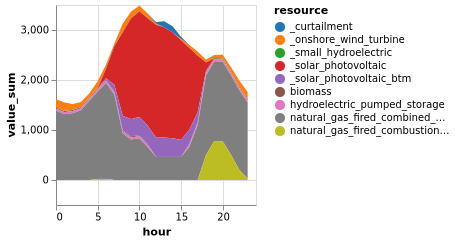

In [5]:
# Add in BTM solar and curtailment and plot results

sol_gen = innerjoin(solution.gen, 
                    gen_df[!, [:r_id, :resource]], 
                    on = :r_id)
sol_gen = combine(groupby(sol_gen, [:resource, :hour]), 
            :value => sum)

# Rename generators (for plotting purposes)
sol_gen[sol_gen.resource .== "solar_photovoltaic", :resource] .= "_solar_photovoltaic"
sol_gen[sol_gen.resource .== "onshore_wind_turbine", :resource] .= "_onshore_wind_turbine"
sol_gen[sol_gen.resource .== "small_hydroelectric", :resource] .= "_small_hydroelectric"

# BTM solar
btm = DataFrame(resource = repeat(["_solar_photovoltaic_btm"]; outer=length(T_period)), 
    hour = T_period,
    value_sum = gen_variable_multi[gen_variable_multi.gen_full .== "wec_sdge_solar_photovoltaic_1.0",:cf] * 600)
append!(sol_gen, btm)

# Curtailment
curtail = combine(groupby(solution.curtail, [:hour]),
            :value => sum)
curtail[!, :resource] .= "_curtailment"
# rename!(curtail, :curt_sum => :value_sum)
append!(sol_gen, curtail[:,[:resource, :hour, :value_sum]])

# Rescale hours
sol_gen.hour = sol_gen.hour .- T_period[1]

sol_gen |>
@vlplot(:area, 
    x=:hour, y={:value_sum, stack=:zero}, 
    color={"resource:n", scale={scheme="category10"}})

Notice that the combined cycle plants flatten out during the day, but don't shut down due to the need for ramping capabilities in the late afternoon/evening, when solar output falls off and evening demand remains strong. This leads to some curtailment of solar from 11:00 - 16:00, which was not present in the Economic Dispatch model. All curtailment is lumped together as the model does not accurately distinguish between whether wind, solar or hydro is curtailed, which in practice is up to the system operator and depends on a variety of factors such as location, interconnection voltage, etc.

We can examine the commitment status of various units by examining the results in `solution.commit`. 

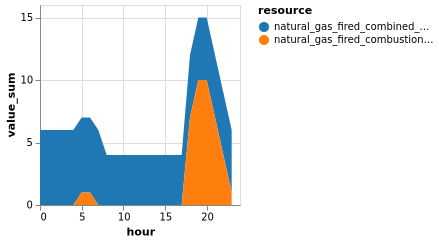

In [6]:
sol_commit = innerjoin(solution.commit, 
                    gen_df[!, [:r_id, :resource]], 
                    on = :r_id)
sol_commit = combine(groupby(sol_commit, [:resource, :hour]), 
            :value => sum)
sol_commit.hour = sol_commit.hour .- T_period[1]

sol_commit |>
@vlplot(:area, 
    x=:hour, y={:value_sum, stack=:zero}, 
    color={"resource:n", scale={scheme="category10"}})

Note that units shutdown during the solar period and startup for the evening peak. However, due to the commitment constraints, not all natural gas plants can be decommitted, resulting in the observed curtailment. A large number of combustion turbines turn on to meet the evening peak.

## Moderate complexity unit commitment

We expand the above unit commitment with ramp equations. These must be modified to prevent ramp violations during the startup process. In order to accommodate this, we introduce an **auxiliary variable** $GENAUX_{g,t}$ defined as the generation above the minimum output (if committed). $GENAUX_{g,t} = GEN_{g,t} = 0$ if the unit is not committed. Auxiliary variables are for convenience (we could always write the whole problem in terms of the original decision variables), but they help de-clutter the model and in general won't add too much computational penalty. The following constraints are added:

$$
\begin{align}
 & GENAUX_{g,t} = GEN_{g,t} - Pmin_{g,t}COMMIT_{g,t} & \forall \quad g \in G_{thermal} , t \in T \\
 & GENAUX_{g,t+1} - GENAUX_{g,t} \leq RampUp_{g} & \forall \quad g \in G_{thermal} , t = 1..T-1 \\
  & GENAUX_{g,t} - GENAUX_{g,t+1} \leq RampDn_{g} & \forall \quad g \in G_{thermal} , t = 1..T-1 \\
 & GEN_{g,t+1} - GEN_{g,t} \leq RampUp_{g} & \forall \quad g \notin G_{thermal} , t = 1..T-1 \\
  & GEN_{g,t} - GEN_{g,t+1} \leq RampDn_{g} & \forall \quad g \notin G_{thermal} , t = 1..T-1  
\end{align}
$$

The creation of this auxiliary variable $GENAUX$ helps us avoid violating ramping constraints when we start up our units and their generation immediately jumps up to their minium output level or during shut-down when a unit drops from minimum output (or above) to zero. 

Note you may encounter alternative formulations in the literature to address this start-up and shut-down that modify the right-hand side of the traditional ramping constraint on total generation to account for the additional step change in output during start-up or shut-down periods. The above formulation is conceptually simple and works well.

### 4. Solve a day's unit commitment

In [7]:
solution = solve_unit_commitment(
    gen_df_sens,
    loads_multi,
    gen_variable_multi,
    0.01,
    ramp_constraints = true); #1% MIP Gap

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2475843
Academic license 2475843 - for non-commercial use only - registered to pa___@imperial.ac.uk
Set parameter MIPGap to value 0.01
Adding ramp constraints...


Set parameter MIPGap to value 0.01
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-11370H @ 3.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2475843 - for non-commercial use only - registered to pa___@imperial.ac.uk
Optimize a model with 4532 rows, 2760 columns and 13296 nonzeros
Model fingerprint: 0x00f527e7
Variable types: 1176 continuous, 1584 integer (1584 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+02]
  Objective range  [5e+00, 5e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 1846 rows and 644 columns
Presolve time: 0.02s
Presolved: 2686 rows, 2116 columns, 10736 nonzeros
Variable types: 576 continuous, 1540 integer (1540 binary)
Found heuristic solution: objective 898512.70762

Root relaxation: objective 8.539093e+05, 959 iterations, 0.01 seconds (0.02 

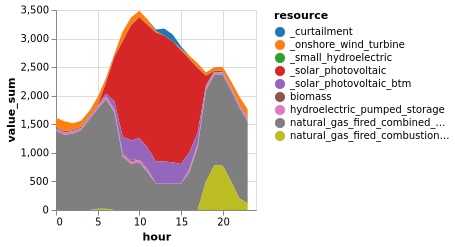

In [8]:
# Add in BTM solar and curtailment and plot results

sol_gen = innerjoin(solution.gen, 
                    gen_df[!, [:r_id, :resource]], 
                    on = :r_id)
sol_gen = combine(groupby(sol_gen, [:resource, :hour]), 
            :value => sum)

# Rename generators (for plotting purposes)
sol_gen[sol_gen.resource .== "solar_photovoltaic", :resource] .= "_solar_photovoltaic"
sol_gen[sol_gen.resource .== "onshore_wind_turbine", :resource] .= "_onshore_wind_turbine"
sol_gen[sol_gen.resource .== "small_hydroelectric", :resource] .= "_small_hydroelectric"

# BTM solar
btm = DataFrame(resource = repeat(["_solar_photovoltaic_btm"]; outer=length(T_period)), 
    hour = T_period,
    value_sum = gen_variable_multi[gen_variable_multi.gen_full .== "wec_sdge_solar_photovoltaic_1.0",:cf] * 600)
append!(sol_gen, btm)

# Curtailment
curtail = combine(groupby(solution.curtail, [:hour]),
            :value => sum)
curtail[!, :resource] .= "_curtailment"
# rename!(curtail, :curt_sum => :value_sum)
append!(sol_gen, curtail[:,[:resource, :hour, :value_sum]])

# Rescale hours
sol_gen.hour = sol_gen.hour .- T_period[1]

sol_gen |>
@vlplot(:area, 
    x=:hour, y={:value_sum, stack=:zero}, 
    color={"resource:n", scale={scheme="category10"}})

In contrast to when we added ramp constraints to the Economic Dispatch problem, adding ramp constraints to our Unit Commitment formulation does not change the solution as much (at least in this case). Much of the inflexibility here arises from the unit commitment constraints, and once committed, there is ample ramping capability. We do however get relatively more combustion turbines running to meet the evening ramp, given their faster ramp rates.

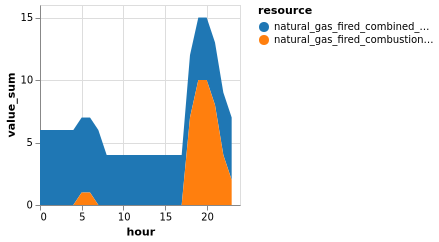

In [9]:
sol_commit = innerjoin(solution.commit, 
                    gen_df[!, [:r_id, :resource]], 
                    on = :r_id)
sol_commit = combine(groupby(sol_commit, [:resource, :hour]), 
            :value => sum)
sol_commit.hour = sol_commit.hour .- T_period[1]

sol_commit |>
@vlplot(:area, 
    x=:hour, y={:value_sum, stack=:zero}, 
    color={"resource:n", scale={scheme="category10"}})

A case involving more large coal or nuclear units with slower ramping limits than gas turbines or combined cycle plants might find ramp constraints more limiting. As in many cases, the impact of constraints is case dependent, and modelers must exercise some judicious application of domain knowledge (and experimentation with alternative formulations) to decide how complex your model should be to reflect important *binding* constraints that actually shape your outcomes of interest. Where constraints are non-binding or second order, it may be more practical to omit them entirely, reducing the computational intensity (solve time) of your model...

## Unit commitment with ramping and reserves

We now add spinning reserve requirements to the model. Spinning reserves refer to generation capacity that is online and able to generate (e.g., within 10-30 minutes) if needed by the system operator. (Note: in Europe, these are referred to as 'replacement reserves' or formerly 'tertiary reserves.') The SO will establish reserve requirements to maintain sufficient capacity to respond to demand or supply forecast errors or in case of "contingencies," such as the unplanned and sudden loss of a generating station or a transmission line. The SO then typically operates a reserve market to competitively procure this available capacity. Most SO's actually define several classes of reserve products defined by their response time and period over which they may be activated. 

Here we will focus on spinning reserve requirements and establish a simple set of reserve requirements for reserves up (ability to quickly increase output) and reserves down (ability to quickly reduce output):

$$
\begin{align}
 & ResReqUp_t = 300 MW + 5\% \times Demand_t  &\forall \quad t \in T \\
 & ResReqDn_t = 5\% \times Demand_t & \forall \quad t \in T
\end{align}
$$

Here, $300 MW$ is our contigency reserves, meant to ensure we have sufficient upwards ramping capability online and available to cover the unexpected loss of 300 MW worth of generation. 

The 5% of demand term in the constraints above is meant to provide sufficient reserves in either upwards or downwards direction to cover errors in the demand forecast. For simplicity, we ignore solar PV and wind production in our reserve calculation, though in practice, we would want to consider solar and wind forecast errors in calculating up reserve requirements as well.

In our simple system, only thermal generators provide reserves. (This can be easily adjusted by changing the sets and defining the potential reserve contributions for different sets of resources differently, such as storage or hydro resources). The contribution of each generators to meeting reserves and the overall reserve constraint are thus given by:

$$
\begin{align}
 & RESUP_{g,t} \leq Pmax_{g,t}COMMIT_{g,t} - GEN_{g,t} & \forall \quad g \in G_{thermal} , t \in T \\
 & RESDN_{g,t} \leq GEN_{g,t} - Pmin_{g,t}COMMIT_{g,t} & \forall \quad g \in G_{thermal} , t \in T \\
 & RESUP_{g,t} \leq RampUp_{g} & \forall \quad g \in G_{thermal}, t \in T\\ 
 & RESDN_{g,t} \leq RampDn_{g} & \forall \quad g \in G_{thermal}, t \in T \\
 & \sum_{g \in G_{thermal}} RESUP_{g,t} \geq ResReqUp_t & \forall \quad t \in T \\
 & \sum_{g \in G_{thermal}} RESDN_{g,t} \geq ResReqDn_t & \forall \quad t \in T
\end{align}
$$

We have added two new **decision variables**:

- $RESUP_{g,t}$, up-reserve capacity (in MW) of generator $g$ at time $t$
- $RESDN_{g,t}$, down-reserve capacity (in MW) of generator $g$ at time $t$

Note that in this case, we constrain the reserve contribution for each thermal generator to be the same as their hourly ramp rates, $RampUp_{g}, RampDown_{g}$. In practice, reserve products typically require a faster response time, on the order of 10-30 minutes for "tertiary" reserves (aka spinning reserves or contingency reserves), and 5-15 minutes for "secondary" reserves (regulation reserves). Thus, depending on the reserve requirements being modeled, one might specify a distinct maximum reserve contribution for each unit that reflects their ramping capabilities over shorter time periods.

<img src="img/reserves.png" style="width: 450px; height: auto" align="left">

<img src="img/reserves_taxonomy.png" style="width: 450px; height: auto" align="left">

### 4. Solve the model and plot results

**Note: this might take a little while depending on your machine.**

In [10]:
reserve = DataFrame(
    hour = loads[in.(loads.hour,Ref(T_period)),:hour],
    up = 300 .+ loads[in.(loads.hour,Ref(T_period)),:demand].*0.05,
    down = loads[in.(loads.hour,Ref(T_period)),:demand].*0.05)
solution = solve_unit_commitment(
    gen_df_sens,
    loads_multi,
    gen_variable_multi,
    0.001,
    ramp_constraints = true,
    reserve = reserve)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2475843
Academic license 2475843 - for non-commercial use only - registered to pa___@imperial.ac.uk
Set parameter MIPGap to value 0.001
Adding ramp constraints...
Adding reserve constraints...


Set parameter MIPGap to value 0.001
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-11370H @ 3.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2475843 - for non-commercial use only - registered to pa___@imperial.ac.uk
Optimize a model with 6692 rows, 3816 columns and 18576 nonzeros
Model fingerprint: 0x89b245e1
Variable types: 2232 continuous, 1584 integer (1584 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+02]
  Objective range  [5e+00, 5e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 2950 rows and 692 columns
Presolve time: 0.02s
Presolved: 3742 rows, 3124 columns, 14768 nonzeros
Variable types: 1584 continuous, 1540 integer (1540 binary)

Root relaxation: objective 8.971854e+05, 3137 iterations, 0.03 seconds (0.04 work units)

    Nodes    |    Current Node   

(gen = 648×3 DataFrame
 Row │ r_id    hour   value     
     │ Int64?  Int64  Float64   
─────┼──────────────────────────
   1 │      1   2401   21.4
   2 │      2   2401   42.0
   3 │      3   2401  320.741
   4 │      4   2401   16.5
   5 │      5   2401   24.7
   6 │      6   2401  570.0
   7 │      7   2401  149.856
   8 │      8   2401  149.856
  ⋮  │   ⋮       ⋮        ⋮
 642 │     27   2424    0.0
 643 │     28   2424    0.0
 644 │     29   2424    0.0
 645 │     30   2424    0.0
 646 │     31   2424  144.421
 647 │     32   2424    3.18493
 648 │     33   2424    0.0
                633 rows omitted, commit = 528×3 DataFrame
 Row │ r_id    hour   value   
     │ Int64?  Int64  Float64 
─────┼────────────────────────
   1 │      3   2401      1.0
   2 │      4   2401      1.0
   3 │      5   2401      1.0
   4 │      6   2401      1.0
   5 │      7   2401      1.0
   6 │      8   2401      1.0
   7 │      9   2401      0.0
   8 │     10   2401      0.0
  ⋮  │   ⋮       ⋮       ⋮

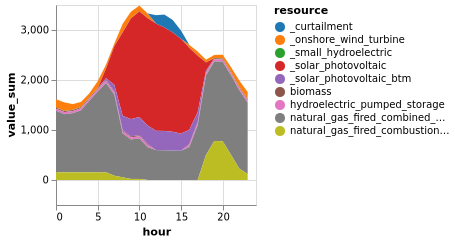

In [11]:

 # To keep solve times to a few minutes, we increase the MIP gap tolerance
 # in this more complex case to 2% (mip_gap=0.02). You can play with this setting to see 
 # how the MIP gap affects solve times on your computer.
   

# Add in BTM solar and curtailment and plot results

sol_gen = innerjoin(solution.gen, 
                    gen_df[!, [:r_id, :resource]], 
                    on = :r_id)
sol_gen = combine(groupby(sol_gen, [:resource, :hour]), 
            :value => sum)

# Rename generators (for plotting purposes)
sol_gen[sol_gen.resource .== "solar_photovoltaic", :resource] .= "_solar_photovoltaic"
sol_gen[sol_gen.resource .== "onshore_wind_turbine", :resource] .= "_onshore_wind_turbine"
sol_gen[sol_gen.resource .== "small_hydroelectric", :resource] .= "_small_hydroelectric"

# BTM solar
btm = DataFrame(resource = repeat(["_solar_photovoltaic_btm"]; outer=length(T_period)), 
    hour = T_period,
    value_sum = gen_variable_multi[gen_variable_multi.gen_full .== "wec_sdge_solar_photovoltaic_1.0",:cf] * 600)
append!(sol_gen, btm)

# Curtailment
curtail = combine(groupby(solution.curtail, [:hour]),
            :value => sum)
curtail[!, :resource] .= "_curtailment"
# rename!(curtail, :curt_sum => :value_sum)
append!(sol_gen, curtail[:,[:resource, :hour, :value_sum]])

# Rescale hours
sol_gen.hour = sol_gen.hour .- T_period[1]

sol_gen |>
@vlplot(:area, 
    x=:hour, y={:value_sum, stack=:zero}, 
    color={"resource:n", scale={scheme="category10"}})

We can now see that the need to maintain reserve requirements leads to greater commitment of natural gas units throughout the day. The addition of CCGTs and GTs to meet reserve requirements leads to greater curtailment of wind and solar in the afternoon hours. We also see more CT units committed during the morning ramp as well as the afternoon hours to help provide reserves.

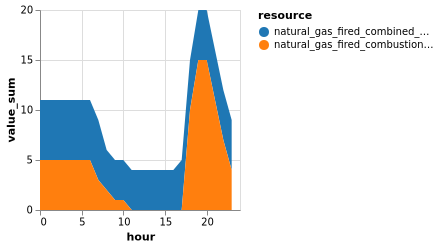

In [12]:
sol_commit = innerjoin(solution.commit, 
                    gen_df[!, [:r_id, :resource]], 
                    on = :r_id)
sol_commit = combine(groupby(sol_commit, [:resource, :hour]), 
            :value => sum)
sol_commit.hour = sol_commit.hour .- T_period[1]

sol_commit |>
@vlplot(:area, 
    x=:hour, y={:value_sum, stack=:zero}, 
    color={"resource:n", scale={scheme="category10"}})

### Further resources

Knueven, B., Ostrowski, J., & Watson, J.-P. (2019). On Mixed Integer Programming Formulations for the Unit Commitment Problem. Optimization Online, 91. http://www.optimization-online.org/DB_FILE/2018/11/6930.pdf

Morales-Espana, G., Latorre, J. M., & Ramos, A. (2013). Tight and Compact MILP Formulation of Start-Up and Shut-Down Ramping in Unit Commitment. IEEE Transactions on Power Systems, 28(2), 1288–1296. https://doi.org/10.1109/TPWRS.2012.2222938

Morales-España, G., Ramírez-Elizondo, L., & Hobbs, B. F. (2017). Hidden power system inflexibilities imposed by traditional unit commitment formulations. Applied Energy, 191, 223–238. https://doi.org/10.1016/j.apenergy.2017.01.089

Ostrowski, J., Anjos, M. F., & Vannelli, A. (2012). Tight Mixed Integer Linear Programming Formulations for the Unit Commitment Problem. IEEE Transactions on Power Systems, 27(1), 39–46. https://doi.org/10.1109/TPWRS.2011.2162008